In [1]:
from Environment.WM import WMEnv
import torch                                    
import torch.nn as nn                           
import torch.nn.functional as F                 
import numpy as np                              
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Construct DQN                            

class Net(nn.Module):
    def __init__(self):                                                        
        super(Net, self).__init__()                                            
        self.fc1 = nn.Linear(N_STATES, 50)                                      
        self.fc1.weight.data.normal_(0, 0.1)                                   
        self.out = nn.Linear(50, N_ACTIONS)                                     
        self.out.weight.data.normal_(0, 0.1)                                    

    def forward(self, x):                                                       
        x = F.relu(self.fc1(x))                                                 # relu or leaky_relu
        actions_value = self.out(x)                                            
        return actions_value                                                  



class DQN(object):
    def __init__(self):                                                         
        self.eval_net, self.target_net = Net(), Net()                           
        self.learn_step_counter = 0                                             
        self.memory_counter = 0                                                 
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))             # shape 2400 * 10 interactions are stored in form of (s, a, r, s_)
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)    
        self.loss_func = nn.MSELoss()
        self.loss_memory = []                                          

    def choose_action(self, x):                                                 # Epsilon-Greedy Strategy
        x = torch.unsqueeze(torch.FloatTensor(x), 0)                          
        if np.random.uniform() < EPSILON:                                                
            actions_value = self.eval_net.forward(x)                           
            action = torch.max(actions_value, 1)[1].data.numpy()                 
            action = action[0]                                                 
        else:                                                                   
            action = np.random.randint(0, N_ACTIONS)                         
        return action                                                          

    def store_transition(self, s, a, r, s_):                                   
        transition = np.hstack((s, [a, r], s_))                                 
        index = self.memory_counter % MEMORY_CAPACITY                           
        self.memory[index, :] = transition                                      
        self.memory_counter += 1                                                

    def learn(self):                           
        # Synchronize target net with evaluation net in every TARGET_REPLACE_ITER step                                 
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:                 
            self.target_net.load_state_dict(self.eval_net.state_dict())         
        self.learn_step_counter += 1                                            
        # Calculating q_eval and q_target, and compute the loss to do backpropagation and update weights
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)            # Randomly sample interaction sequences (s, a, r, s_) for learning,
        b_memory = self.memory[sample_index, :]                                 # where s is current state, a is action, r is reward and s_ is new state
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])                         # Extract current state from the memory array
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))    # Extract action from the memory array
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])             # Extract reward from the memory array
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])                       # Extract new state from the memory
        q_eval = self.eval_net(b_s).gather(1, b_a)                              # Compute the q value for taking the action b_a based on the current state b_s
        q_next = self.target_net(b_s_).detach()                                 # Compute the q values for all possible actions based on the new state b_s_
                                                                                # using .detach() to return tensor that does not require gradient so that weights
                                                                                # will not be updated in target net                                                                              
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)           # Compute q_target, similar to bellman equation in tabular q-learning
        loss = self.loss_func(q_eval, q_target)                                 # Compute loss
        self.loss_memory.append(loss)                                           # append loss to a list so that we can visualize
        self.optimizer.zero_grad()                                              # The rest code is to do backpropagation and updating weights
        loss.backward()                                                 
        self.optimizer.step()

In [3]:
df = pd.read_csv('Datasets/df.csv')

In [4]:
# Define hyperparameters
BATCH_SIZE = 64                               
LR = 0.1                                   
EPSILON = 0.99                               
GAMMA = 0.9                                     
TARGET_REPLACE_ITER = 1000                 
MEMORY_CAPACITY = 2400                                 
N_ACTIONS = 2                                   
N_STATES = 6

# Load environment and DQN
env = WMEnv(df, 8, 22, 5, 10, 10, 10) 
dqn = DQN() 

# Load previous training weights 
# dqn.eval_net.load_state_dict(torch.load('eval_weights_v8.pth'))        
# dqn.target_net.load_state_dict(torch.load('target_weights_v8.pth'))    


# Start training
reward = []
numope = []
energy = []
loss = []
total_energy = []

episode = 10000
for i in range(episode): # each episode contains 24 steps(hours)
    if i % 10 == 0:                                                  
      print('<<<<<<<<<Episode: %s' % i)
    s = env.reset()                                               
    episode_reward_sum = 0 
    # #set value for epsilon greedy strategy      
    if i < episode//2:
      EPSILON = 0.8
    else:
      EPSILON = 0.99            
    while True:            
        # Interaction                                        
        a = dqn.choose_action(s)                                    
        s_, r, done, info = env.step(a)                                
        # Save experience sequences
        dqn.store_transition(s, a, r, s_)                 
        episode_reward_sum += r                           
        s = s_                                                

        if dqn.memory_counter > MEMORY_CAPACITY:
          dqn.learn()

        if done: 
          # print('episode%s---reward_sum: %s' % (i, round(episode_reward_sum, 2)))
          # print(f'number of operations:{env.cur_ope}')
          # print(f'total energy cost:{env.energy_cost}')
          energy.append(env.total_energy_cost)
          reward.append(round(episode_reward_sum,2))
          numope.append(env.cur_ope)
          total_energy.append(env.total_net_energy_cost)
          if i == episode - 1:
            print('saving model')
            torch.save(dqn.eval_net.state_dict(), 'dqn_eval_weights_v1.pth')        # Saving eval_net weights as .pth file
            torch.save(dqn.target_net.state_dict(), 'dqn_target_weights_v1.pth')    # Saving target_net weights as .pth file
          break

<<<<<<<<<Episode: 0
<<<<<<<<<Episode: 10
<<<<<<<<<Episode: 20
<<<<<<<<<Episode: 30
<<<<<<<<<Episode: 40
<<<<<<<<<Episode: 50
<<<<<<<<<Episode: 60
<<<<<<<<<Episode: 70
<<<<<<<<<Episode: 80
<<<<<<<<<Episode: 90
<<<<<<<<<Episode: 100
<<<<<<<<<Episode: 110
<<<<<<<<<Episode: 120
<<<<<<<<<Episode: 130
<<<<<<<<<Episode: 140
<<<<<<<<<Episode: 150
<<<<<<<<<Episode: 160
<<<<<<<<<Episode: 170
<<<<<<<<<Episode: 180
<<<<<<<<<Episode: 190
<<<<<<<<<Episode: 200
<<<<<<<<<Episode: 210
<<<<<<<<<Episode: 220
<<<<<<<<<Episode: 230
<<<<<<<<<Episode: 240
<<<<<<<<<Episode: 250
<<<<<<<<<Episode: 260
<<<<<<<<<Episode: 270
<<<<<<<<<Episode: 280
<<<<<<<<<Episode: 290
<<<<<<<<<Episode: 300
<<<<<<<<<Episode: 310
<<<<<<<<<Episode: 320
<<<<<<<<<Episode: 330
<<<<<<<<<Episode: 340
<<<<<<<<<Episode: 350
<<<<<<<<<Episode: 360
<<<<<<<<<Episode: 370
<<<<<<<<<Episode: 380
<<<<<<<<<Episode: 390
<<<<<<<<<Episode: 400
<<<<<<<<<Episode: 410
<<<<<<<<<Episode: 420
<<<<<<<<<Episode: 430
<<<<<<<<<Episode: 440
<<<<<<<<<Episode: 450

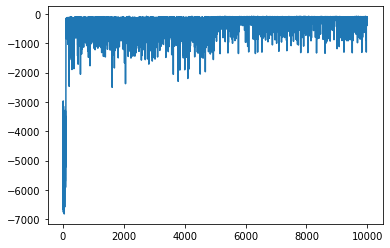

In [5]:
sns.lineplot(x = list(range(episode)), y = reward)

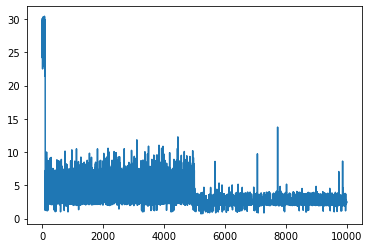

In [6]:
sns.lineplot(x = list(range(episode)), y = energy)

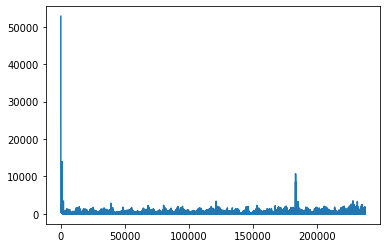

In [7]:
l = [i.item() for i in dqn.loss_memory]
sns.lineplot(x=list(range(len(l))), y = l)

In [18]:
# Testing
date = []
time = []
price = []
en_cost = []
total_en = []

# Randomly sample 5 days for testing
for episode in range(5): 
  s = env.reset()
  EPSILON = 1
  while True:
    action = dqn.choose_action(s)
    date.append(env.cur_date)
    time.append(env.time)
    price.append(env.price)
    s_, rewards, done, info = env.step(action) 
    en_cost.append(env.cur_energy)
    #env.render(action)
    s = s_
    if done:
      total_en.append(env.total_energy_cost)
      break

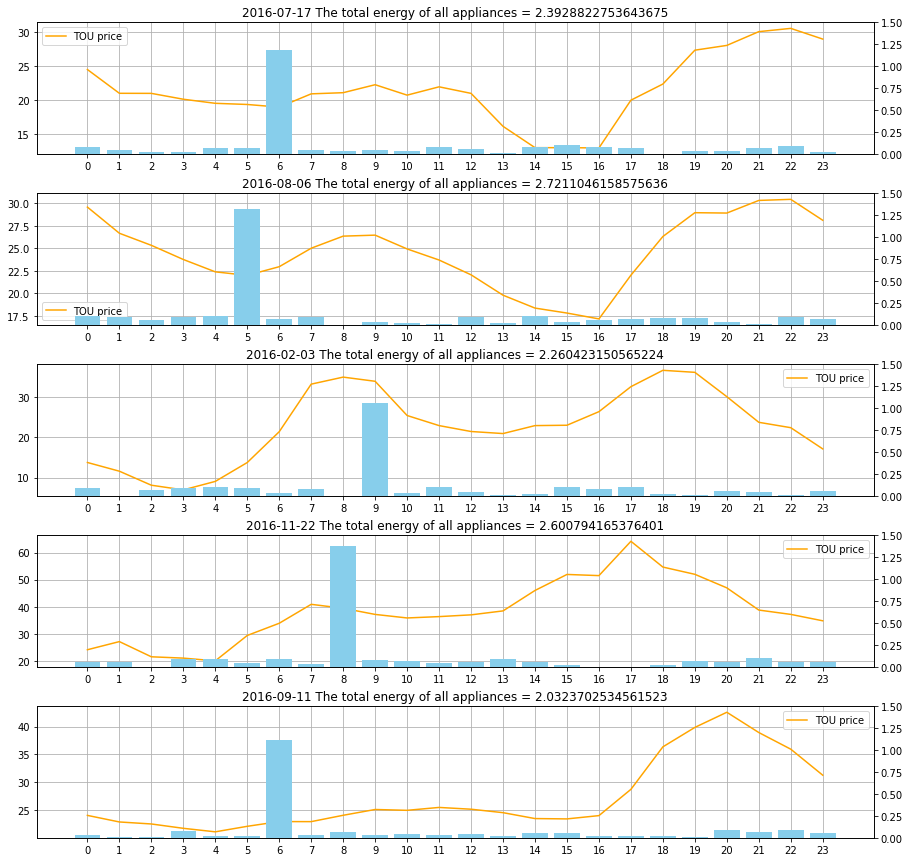

In [19]:
re = pd.DataFrame({'date':date, 't':time, 'energy_cost':en_cost, 'price':price })
d = list(re.date.unique())
fig, axes = plt.subplots(5,1,figsize = (15,15))
plt.subplots_adjust(hspace = 0.3)
for i in range(5):
  axes2 = axes[i].twinx()
  axes[i].plot(re[re.date == d[i]].t, re[re.date == d[i]].price, color = 'orange')
  axes2.bar(re[re.date == d[i]].t, re[re.date == d[i]].energy_cost, color = 'skyblue')
  axes2.set_ylim([0, 1.5])
  axes[i].grid()
  axes[i].title.set_text(d[i] + ' The total energy of all appliances = ' + str(total_en[i]))
  axes[i].legend(['TOU price'])
  plt.xticks(np.arange(0,24))
plt.show()